In [1]:
import netCDF4 as nc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas
import xarray as xr
import matplotlib.colors as pltc
import geopandas
import datetime as dt
from scipy import stats
from sklearn import preprocessing
import s3fs
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

## Cubic feet to cubic meters conversion factor
cfs_2_cms = 0.0283168466

In [2]:
pnwNP = pd.read_csv("../data/pnwNP_Info.csv")

# SF Teton River Near Rexburg, ID 13055340, Mill Creek at Walla Walla, WA 14015000, Camas Creek at Camas, ID 13112000
gages = [13055340, 14015000,13112000]

# Subset gages
pnwSub = pnwNP[pnwNP['gage'].isin(gages)]


### Pull out sites
## SF Teton 5359, Mill Creek 1928, Camas 842
shp = geopandas.read_file("../data/VIC_UW/shapefiles/columbia_seg.shp")
shp = shp.loc[shp['POI_ID'].isin(pnwSub["comid"])]
seg_ids = np.array(shp['seg_id'])

In [3]:
## Open modeled datasets and extract data at segment locations.
pnwVIC = xr.open_mfdataset('../data/VIC_UW/pnwNP_Gages_VIC.nc')
pnwVIC = pnwVIC.where(pnwVIC['reachID'].isin(seg_ids),drop=True)

pnwPRMS = xr.open_mfdataset('../data/VIC_UW/pnwNP_Gages_PRMS.nc')
pnwPRMS = pnwPRMS.where(pnwPRMS['reachID'].isin(seg_ids),drop=True)


## Open NWM from NOAA AWS bucket
s3_path = 's3://noaa-nwm-retro-v2-zarr-pds' #nwm 2.0

# Connect to S3
s3 = s3fs.S3FileSystem(anon=True)
store = s3fs.S3Map(root=s3_path, s3=s3, check=False)

# load the dataset
ds = xr.open_zarr(store=store, consolidated=True)


## Teton River

In [4]:
## Teton Riv
fields = ['X_00060_00003', 'Date']
seg= 5359
reach_id = 24471640 # COMID

## Get Vic data
tetVIC = pnwVIC.where(pnwVIC['reachID']==seg,drop=True).to_dataframe()
tetVIC = tetVIC.drop(['reachID'],axis=1)
tetVIC= tetVIC.droplevel('seg')
tetVIC['time'] = pd.to_datetime(tetVIC.index,)
tetVIC['time'] = tetVIC['time'].dt.tz_localize(None)
tetVIC = tetVIC.reset_index(drop=True)
tetVIC.columns = ["streamflow_VIC","time"]

## Get PRMS data
tetPRMS = pnwPRMS.where(pnwPRMS['reachID']==seg,drop=True).to_dataframe()
tetPRMS = tetPRMS.drop(['reachID'],axis=1)
tetPRMS= tetPRMS.droplevel('seg')
tetPRMS['time'] = pd.to_datetime(tetPRMS.index,)
tetPRMS['time'] = tetPRMS['time'].dt.tz_localize(None)
tetPRMS = tetPRMS.reset_index(drop=True)
tetPRMS.columns = ["streamflow_PRMS","time"]

## Combine
tetALL = pd.merge(tetVIC,tetPRMS, on='time',how='inner')

## Get NWM 2.0 data
# slice all data using a specific reach identifier and time range
timerange = slice('1979-01-31', '2011-12-31')
dat = ds.sel(feature_id=reach_id,
             time=timerange).streamflow.persist() 

# This step takes a bit longer because it's actually returning the data
dat = dat.resample(time='1d').mean()

tetNWM = pd.DataFrame(dat.to_pandas())
tetNWM['time'] = pd.to_datetime(tetNWM.index)
tetNWM.columns = ["streamflow_NWM2d0","time"]
tetNWM = tetNWM.reset_index(drop=True)
tetNWM


## Combine with above datasets
tetALL = pd.merge(tetALL,tetNWM, on='time',how='inner')

# ## Get NWIS Data

tetNWIS = pd.read_csv('../data/NWIS_streamflow/13055340.csv',usecols=fields)
tetNWIS.columns = ["time","streamflow_NWIS"]
tetNWIS['time'] = pd.to_datetime(tetNWIS['time']).dt.tz_localize(None)
tetNWIS["streamflow_NWIS"] = tetNWIS["streamflow_NWIS"]*cfs_2_cms

## Combine all the data
tetALL = pd.merge(tetALL,tetNWIS, on='time',how='inner')


KeyboardInterrupt: 

In [ ]:
## Make a normalized dataframe for plotting
tt = tetALL
tt.index = tetALL['time']
tt =  tt.drop('time',axis=1)
tt = pd.DataFrame(preprocessing.minmax_scale(tt))
tt.index = tetALL['time']
tt.columns = ["streamflow_VIC","streamflow_PRMS","streamflow_NWM2d0","streamflow_NWIS"]

Text(0.5, 1.0, 'South Fork Teton River near Rexburg, Idaho')

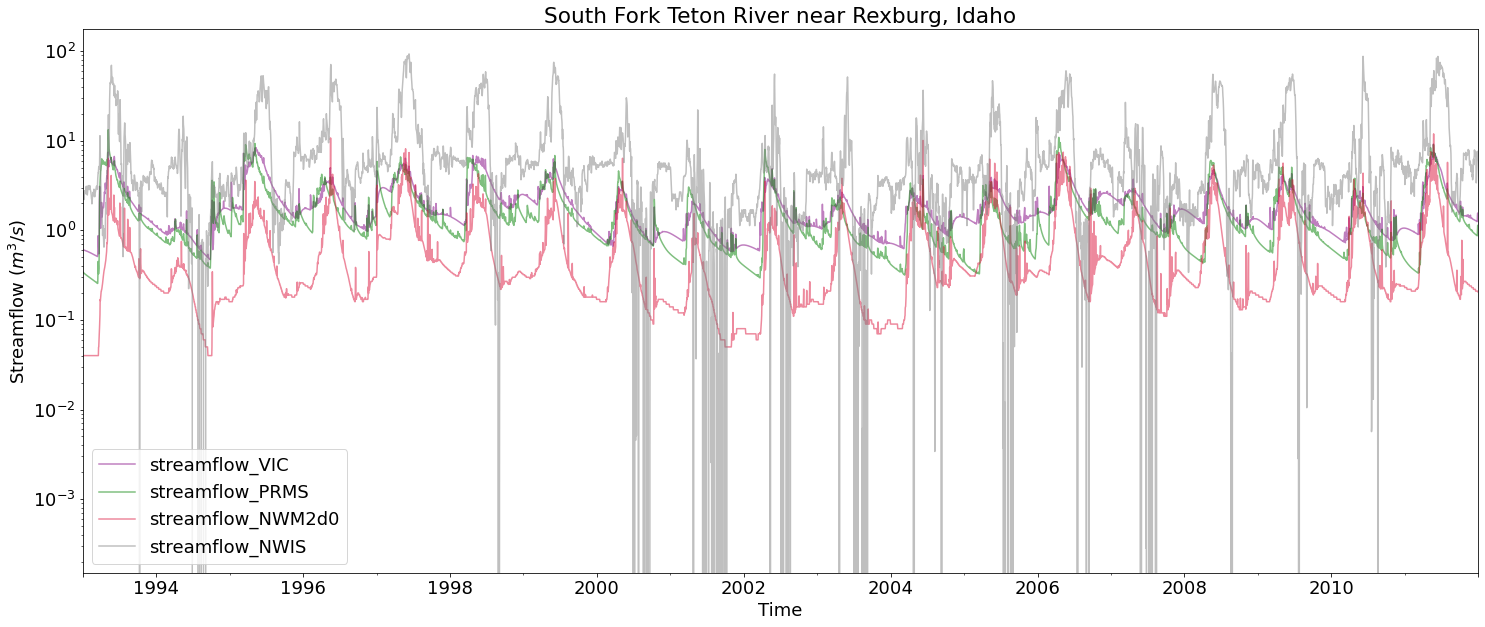

In [14]:
plt.rcParams.update({'font.size': 18})

ax = tetALL.plot(x = "time",figsize = (25,10),logy=True,alpha=0.5,color = ['purple','green','crimson','grey'])
ax.set_xlabel('Time')
ax.set_ylabel('Streamflow $(m^3/s)$')
ax.set_title("South Fork Teton River near Rexburg, Idaho")
# plt.savefig("../docs/SFTeton_streamflow.pdf")

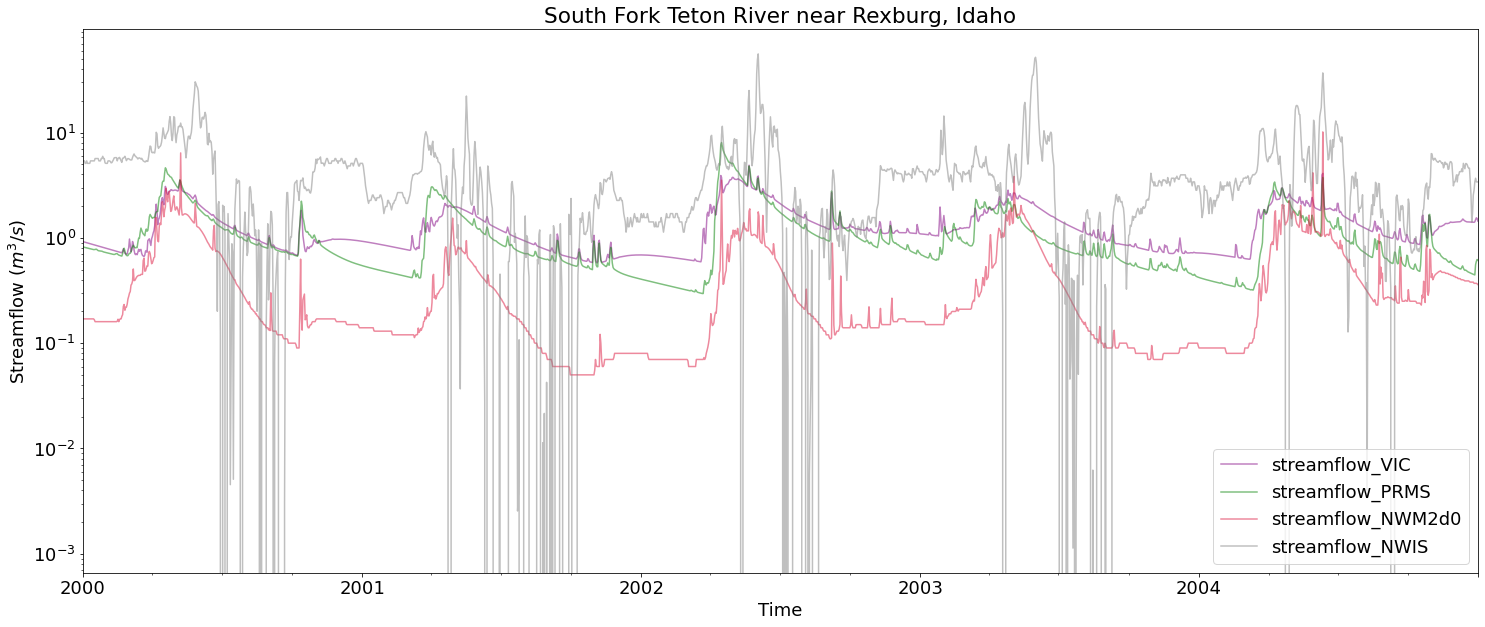

In [15]:
sub = tetALL[ (tetALL["time"] >= '2000-01-01') & (tetALL["time"] <= '2004-12-31')]
ax = sub.plot(x = "time",figsize = (25,10),logy=True,alpha=0.5,color = ['purple','green','crimson','grey'])
ax.set_xlabel('Time')
ax.set_ylabel('Streamflow $(m^3/s)$')
ax.set_title("South Fork Teton River near Rexburg, Idaho")
plt.savefig("../docs/SFTeton_streamflowSubset.pdf")

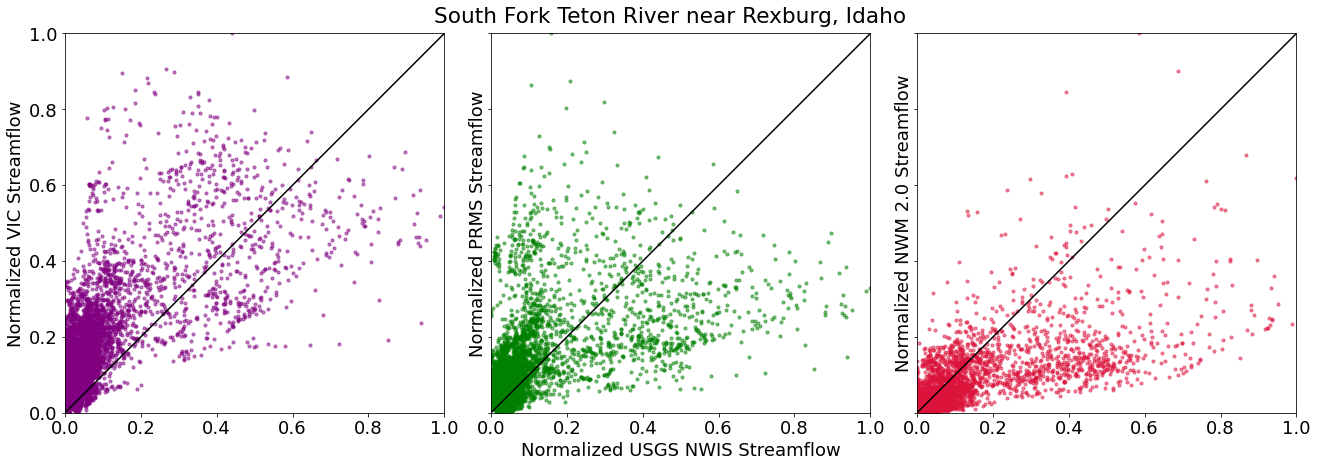

In [16]:
fig, axs = plt.subplots(1,3, sharey=True,figsize=(18,6),subplot_kw=dict(box_aspect=1))
fig.suptitle('South Fork Teton River near Rexburg, Idaho')


pt = (0, 0)
plt.tight_layout(pad=0.4, w_pad=1, h_pad=0.5)
axs[0].scatter(x = tt["streamflow_NWIS"],y=tt["streamflow_VIC"],alpha = 0.5,color = "purple",s=10)
axs[1].scatter(x = tt["streamflow_NWIS"],y=tt["streamflow_PRMS"],alpha = 0.5,color = 'green',s=10)
axs[2].scatter(x = tt["streamflow_NWIS"],y=tt["streamflow_NWM2d0"],alpha = 0.5,color = 'crimson',s=10)
axs[0].axline(pt,slope=1, color='black')
axs[1].axline(pt,slope=1, color='black')
axs[2].axline(pt,slope=1, color='black')
axs[0].set_ylabel('Normalized VIC Streamflow')
axs[1].set_ylabel('Normalized PRMS Streamflow')
axs[2].set_ylabel('Normalized NWM 2.0 Streamflow')
axs[1].set_xlabel('Normalized USGS NWIS Streamflow')
axs[0].set_ylim(0,1)
axs[0].set_xlim(0,1)
axs[1].set_ylim(0,1)
axs[1].set_xlim(0,1)
axs[2].set_ylim(0,1)
axs[2].set_xlim(0,1)

plt.savefig("../docs/SFTeton_1to1.pdf",bbox_inches='tight')

## Mill Creek

In [17]:
fields = ['X_00060_00003', 'Date']
seg= 1928
reach_id = 23637700 # COMID

## Get Vic data
tetVIC = pnwVIC.where(pnwVIC['reachID']==seg,drop=True).to_dataframe()
tetVIC = tetVIC.drop(['reachID'],axis=1)
tetVIC= tetVIC.droplevel('seg')
tetVIC['time'] = pd.to_datetime(tetVIC.index,)
tetVIC['time'] = tetVIC['time'].dt.tz_localize(None)
tetVIC = tetVIC.reset_index(drop=True)
tetVIC.columns = ["streamflow_VIC","time"]

## Get PRMS data
tetPRMS = pnwPRMS.where(pnwPRMS['reachID']==seg,drop=True).to_dataframe()
tetPRMS = tetPRMS.drop(['reachID'],axis=1)
tetPRMS= tetPRMS.droplevel('seg')
tetPRMS['time'] = pd.to_datetime(tetPRMS.index,)
tetPRMS['time'] = tetPRMS['time'].dt.tz_localize(None)
tetPRMS = tetPRMS.reset_index(drop=True)
tetPRMS.columns = ["streamflow_PRMS","time"]

## Combine
tetALL = pd.merge(tetVIC,tetPRMS, on='time',how='inner')

## Get NWM 2.0 data
# slice all data using a specific reach identifier and time range
timerange = slice('1979-01-31', '2011-12-31')
dat = ds.sel(feature_id=reach_id,
             time=timerange).streamflow.persist() 

# This step takes a bit longer because it's actually returning the data
dat = dat.resample(time='1d').mean()

tetNWM = pd.DataFrame(dat.to_pandas())
tetNWM['time'] = pd.to_datetime(tetNWM.index)
tetNWM.columns = ["streamflow_NWM2d0","time"]
tetNWM = tetNWM.reset_index(drop=True)
tetNWM


## Combine with above datasets
tetALL = pd.merge(tetALL,tetNWM, on='time',how='inner')

# ## Get NWIS Data

tetNWIS = pd.read_csv('../data/NWIS_streamflow/14015000.csv',usecols=fields)
tetNWIS.columns = ["time","streamflow_NWIS"]
tetNWIS['time'] = pd.to_datetime(tetNWIS['time']).dt.tz_localize(None)
tetNWIS["streamflow_NWIS"] = tetNWIS["streamflow_NWIS"]*cfs_2_cms

## Combine all the data
tetALL = pd.merge(tetALL,tetNWIS, on='time',how='inner')


In [18]:
## Make a normalized dataframe for plotting
tt = tetALL
tt.index = tetALL['time']
tt =  tt.drop('time',axis=1)
tt = pd.DataFrame(preprocessing.minmax_scale(tt))
tt.index = tetALL['time']
tt.columns = ["streamflow_VIC","streamflow_PRMS","streamflow_NWM2d0","streamflow_NWIS"]

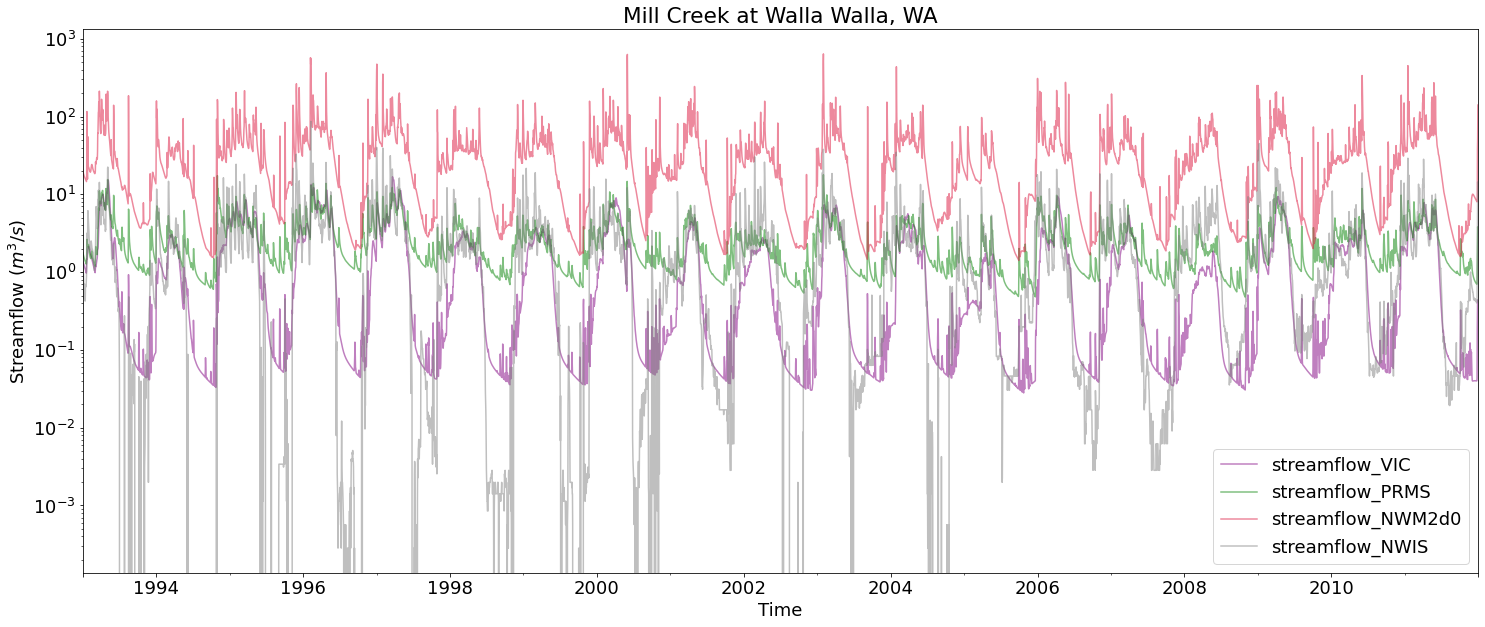

In [19]:
ax = tetALL.plot(x = "time",figsize = (25,10),logy=True,alpha=0.5,color = ['purple','green','crimson','grey'])
ax.set_xlabel('Time')
ax.set_ylabel('Streamflow $(m^3/s)$')
ax.set_title("Mill Creek at Walla Walla, WA")
plt.savefig("../docs/MillCreek_streamflow.pdf")

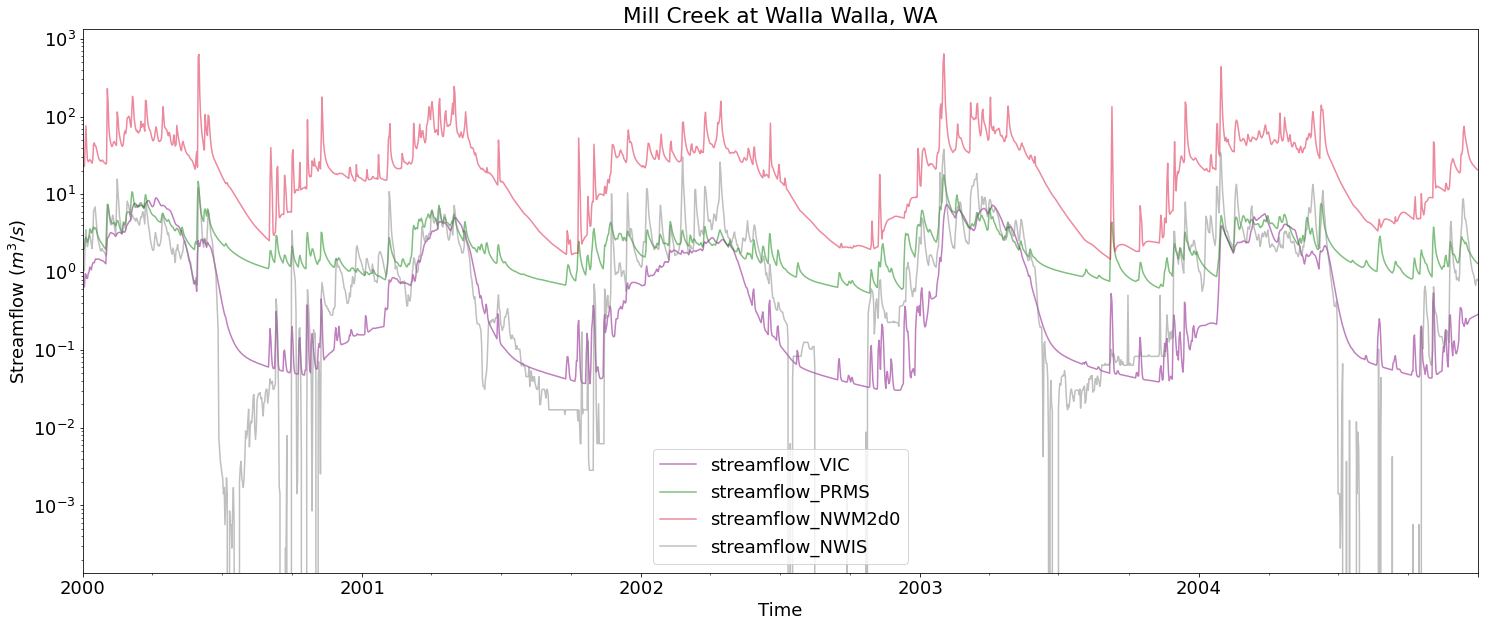

In [20]:
sub = tetALL[ (tetALL["time"] >= '2000-01-01') & (tetALL["time"] <= '2004-12-31')]
ax = sub.plot(x = "time",figsize = (25,10),logy=True,alpha=0.5,color = ['purple','green','crimson','grey'])
ax.set_xlabel('Time')
ax.set_ylabel('Streamflow $(m^3/s)$')
ax.set_title("Mill Creek at Walla Walla, WA")
plt.savefig("../docs/MillCreek_streamflowSubset.pdf")

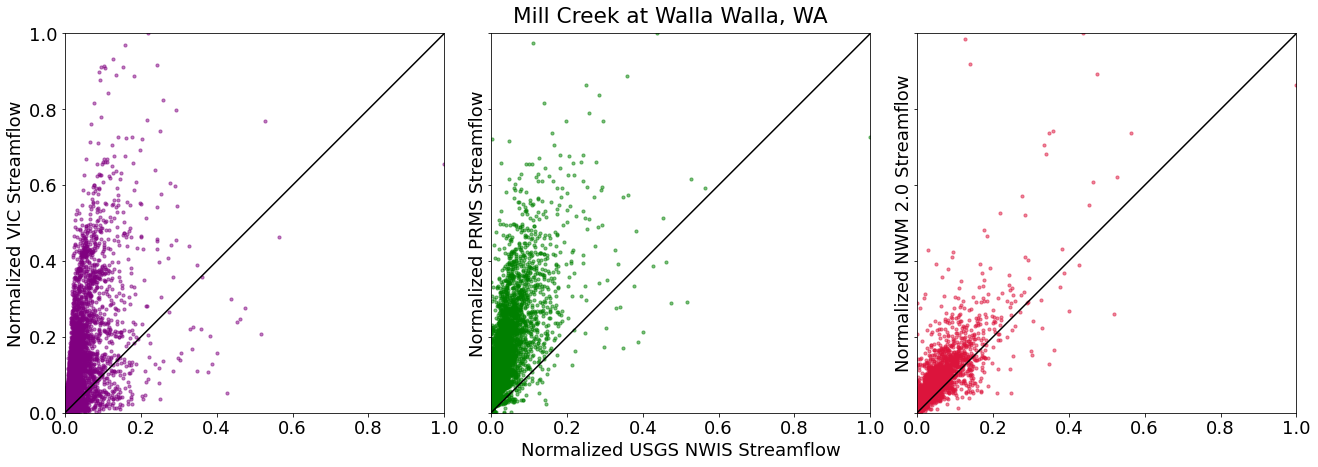

In [21]:
fig, axs = plt.subplots(1,3, sharey=True,figsize=(18,6),subplot_kw=dict(box_aspect=1))
fig.suptitle('Mill Creek at Walla Walla, WA')


pt = (0, 0)
plt.tight_layout(pad=0.4, w_pad=1, h_pad=0.5)
axs[0].scatter(x = tt["streamflow_NWIS"],y=tt["streamflow_VIC"],alpha = 0.5,color = "purple",s=10)
axs[1].scatter(x = tt["streamflow_NWIS"],y=tt["streamflow_PRMS"],alpha = 0.5,color = 'green',s=10)
axs[2].scatter(x = tt["streamflow_NWIS"],y=tt["streamflow_NWM2d0"],alpha = 0.5,color = 'crimson',s=10)
axs[0].axline(pt,slope=1, color='black')
axs[1].axline(pt,slope=1, color='black')
axs[2].axline(pt,slope=1, color='black')
axs[0].set_ylabel('Normalized VIC Streamflow')
axs[1].set_ylabel('Normalized PRMS Streamflow')
axs[2].set_ylabel('Normalized NWM 2.0 Streamflow')
axs[1].set_xlabel('Normalized USGS NWIS Streamflow')
axs[0].set_ylim(0,1)
axs[0].set_xlim(0,1)
axs[1].set_ylim(0,1)
axs[1].set_xlim(0,1)
axs[2].set_ylim(0,1)
axs[2].set_xlim(0,1)

plt.savefig("../docs/MillCreek_1to1.pdf",bbox_inches='tight')

## Camas Creek

In [22]:
fields = ['X_00060_00003', 'Date']
seg= 842
reach_id = 23223074 # COMID

## Get Vic data
tetVIC = pnwVIC.where(pnwVIC['reachID']==seg,drop=True).to_dataframe()
tetVIC = tetVIC.drop(['reachID'],axis=1)
tetVIC= tetVIC.droplevel('seg')
tetVIC['time'] = pd.to_datetime(tetVIC.index,)
tetVIC['time'] = tetVIC['time'].dt.tz_localize(None)
tetVIC = tetVIC.reset_index(drop=True)
tetVIC.columns = ["streamflow_VIC","time"]

## Get PRMS data
tetPRMS = pnwPRMS.where(pnwPRMS['reachID']==seg,drop=True).to_dataframe()
tetPRMS = tetPRMS.drop(['reachID'],axis=1)
tetPRMS= tetPRMS.droplevel('seg')
tetPRMS['time'] = pd.to_datetime(tetPRMS.index,)
tetPRMS['time'] = tetPRMS['time'].dt.tz_localize(None)
tetPRMS = tetPRMS.reset_index(drop=True)
tetPRMS.columns = ["streamflow_PRMS","time"]

## Combine
tetALL = pd.merge(tetVIC,tetPRMS, on='time',how='inner')

## Get NWM 2.0 data
# slice all data using a specific reach identifier and time range
timerange = slice('1979-01-31', '2011-12-31')
dat = ds.sel(feature_id=reach_id,
             time=timerange).streamflow.persist() 

# This step takes a bit longer because it's actually returning the data
dat = dat.resample(time='1d').mean()

tetNWM = pd.DataFrame(dat.to_pandas())
tetNWM['time'] = pd.to_datetime(tetNWM.index)
tetNWM.columns = ["streamflow_NWM2d0","time"]
tetNWM = tetNWM.reset_index(drop=True)
tetNWM


## Combine with above datasets
tetALL = pd.merge(tetALL,tetNWM, on='time',how='inner')

# ## Get NWIS Data

tetNWIS = pd.read_csv('../data/NWIS_streamflow/13112000.csv',usecols=fields)
tetNWIS.columns = ["time","streamflow_NWIS"]
tetNWIS['time'] = pd.to_datetime(tetNWIS['time']).dt.tz_localize(None)
tetNWIS["streamflow_NWIS"] = tetNWIS["streamflow_NWIS"]*cfs_2_cms

## Combine all the data
tetALL = pd.merge(tetALL,tetNWIS, on='time',how='inner')


In [23]:
## Make a normalized dataframe for plotting
tt = tetALL
tt.index = tetALL['time']
tt =  tt.drop('time',axis=1)
tt = pd.DataFrame(preprocessing.minmax_scale(tt))
tt.index = tetALL['time']
tt.columns = ["streamflow_VIC","streamflow_PRMS","streamflow_NWM2d0","streamflow_NWIS"]

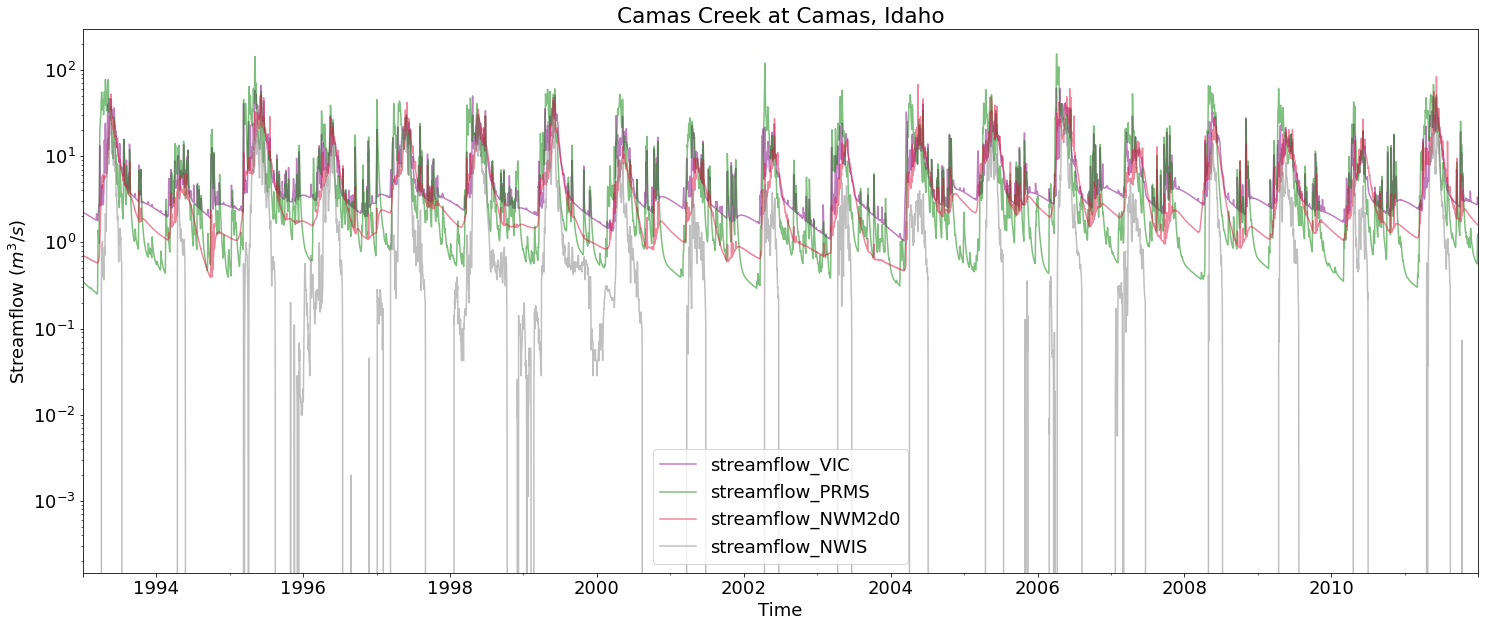

In [24]:
ax = tetALL.plot(x = "time",figsize = (25,10),logy=True,alpha=0.5,color = ['purple','green','crimson','grey'])
ax.set_xlabel('Time')
ax.set_ylabel('Streamflow $(m^3/s)$')
ax.set_title("Camas Creek at Camas, Idaho")
plt.savefig("../docs/camas_streamflow.pdf")

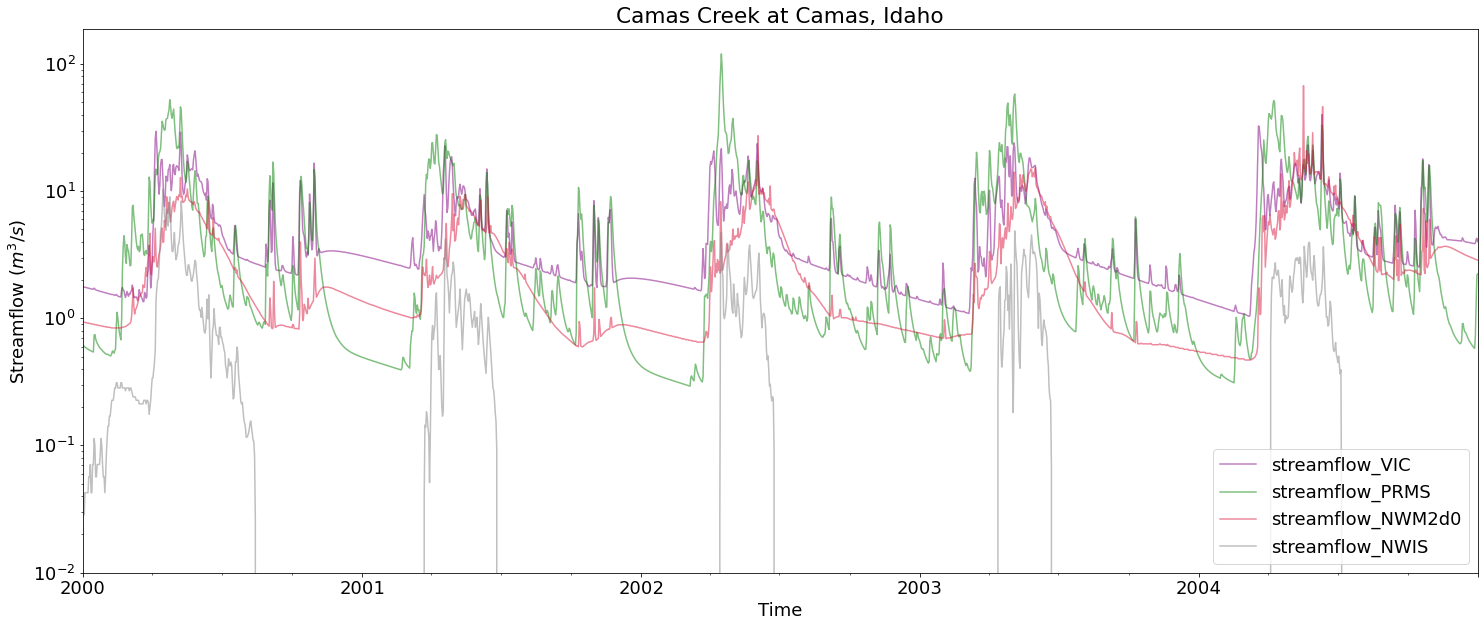

In [25]:
sub = tetALL[ (tetALL["time"] >= '2000-01-01') & (tetALL["time"] <= '2004-12-31')]
ax = sub.plot(x = "time",figsize = (25,10),logy=True,alpha=0.5,color = ['purple','green','crimson','grey'])
ax.set_xlabel('Time')
ax.set_ylabel('Streamflow $(m^3/s)$')
ax.set_title("Camas Creek at Camas, Idaho")
plt.savefig("../docs/camas_streamflowSubset.pdf")

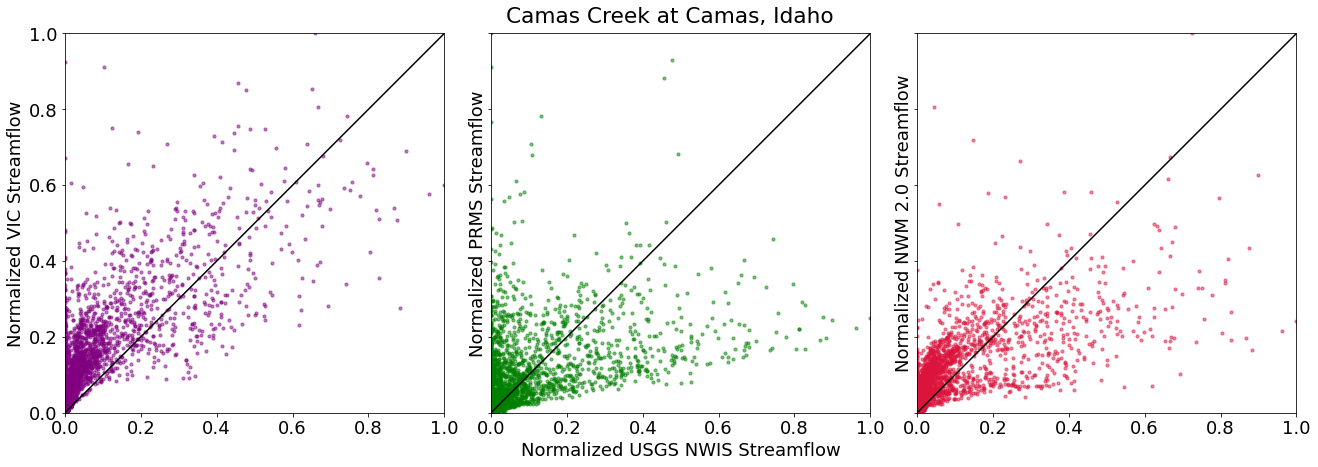

In [26]:
fig, axs = plt.subplots(1,3, sharey=True,figsize=(18,6),subplot_kw=dict(box_aspect=1))
fig.suptitle('Camas Creek at Camas, Idaho')


pt = (0, 0)
plt.tight_layout(pad=0.4, w_pad=1, h_pad=0.5)
axs[0].scatter(x = tt["streamflow_NWIS"],y=tt["streamflow_VIC"],alpha = 0.5,color = "purple",s=10)
axs[1].scatter(x = tt["streamflow_NWIS"],y=tt["streamflow_PRMS"],alpha = 0.5,color = 'green',s=10)
axs[2].scatter(x = tt["streamflow_NWIS"],y=tt["streamflow_NWM2d0"],alpha = 0.5,color = 'crimson',s=10)
axs[0].axline(pt,slope=1, color='black')
axs[1].axline(pt,slope=1, color='black')
axs[2].axline(pt,slope=1, color='black')
axs[0].set_ylabel('Normalized VIC Streamflow')
axs[1].set_ylabel('Normalized PRMS Streamflow')
axs[2].set_ylabel('Normalized NWM 2.0 Streamflow')
axs[1].set_xlabel('Normalized USGS NWIS Streamflow')
axs[0].set_ylim(0,1)
axs[0].set_xlim(0,1)
axs[1].set_ylim(0,1)
axs[1].set_xlim(0,1)
axs[2].set_ylim(0,1)
axs[2].set_xlim(0,1)

plt.savefig("../docs/camas_1to1.png",bbox_inches='tight')

<AxesSubplot:xlabel='time'>

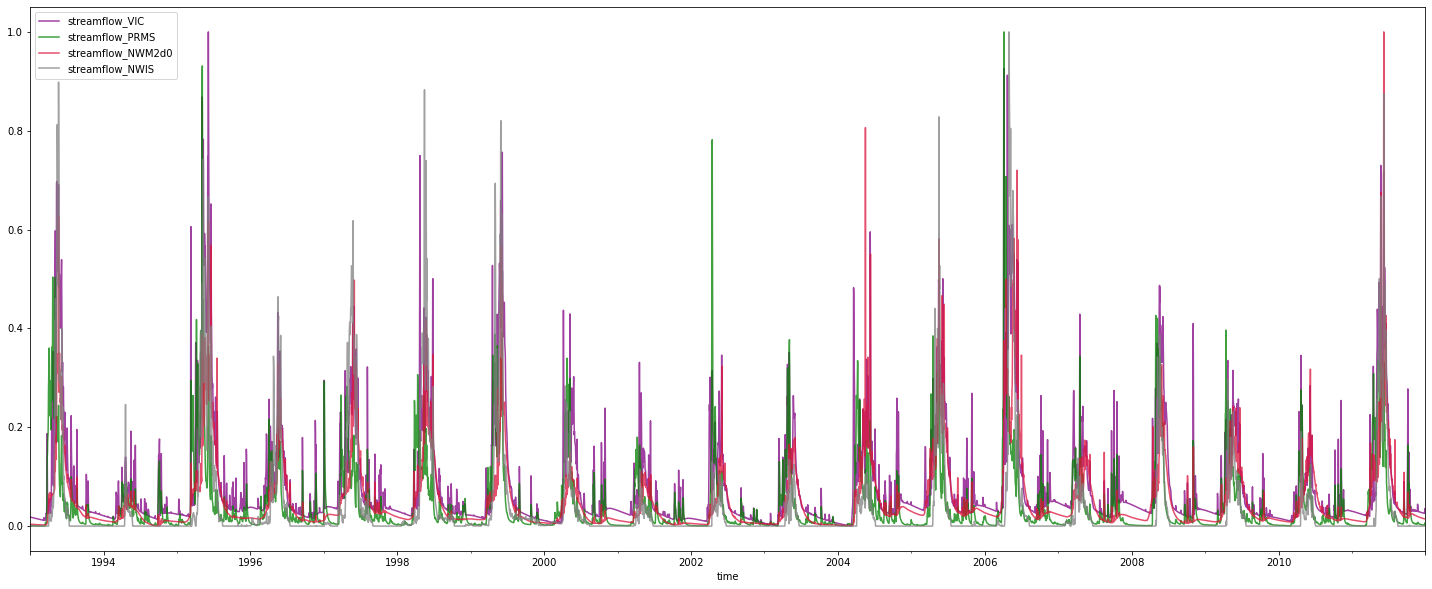

In [19]:
tt.plot(figsize = (25,10),alpha=0.75,color = ['purple','green','crimson','grey'])

# Scratch space

In [ ]:
import os
import pandas
import xarray
import s3fs
import hvplot.xarray

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
plt.gca().set_aspect('equal')
pt = (0, 0)
plt.scatter(x = tt["streamflow_NWIS"],y=tt["streamflow_VIC"],alpha = 0.5,color = "purple")
ax.axline(pt,slope=1, color='black')

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
plt.scatter(x = tt["streamflow_NWIS"],y=tt["streamflow_PRMS"],alpha = 0.5,color = 'green')
pt = (0, 0)
plt.gca().set_aspect('equal')
ax.axline(pt,slope=1, color='black')

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
plt.gca().set_aspect('equal')
pt = (0, 0)
plt.scatter(x = tt["streamflow_NWIS"],y=tt["streamflow_NWM2d0"],alpha = 0.5,color = 'crimson')
ax.axline(pt,slope=1, color='black')

## Visualize NWM Retrospective Streamflow

NWM streamflow will be collected from the public datastore located on AWS. We'll be using the Zarr library to efficiently extract data from this store.

In [ ]:
s3_path = 's3://noaa-nwm-retro-v2-zarr-pds' #nwm 2.0

# Connect to S3
s3 = s3fs.S3FileSystem(anon=True)
store = s3fs.S3Map(root=s3_path, s3=s3, check=False)

# load the dataset
ds = xarray.open_zarr(store=store, consolidated=True)

In [ ]:
# slice all data using a specific reach identifier and time range
reach_id = 23223074 # COMID from map above

timerange = slice('1979-01-31', '2011-12-31')
dat = ds.sel(feature_id=reach_id,
             time=timerange).streamflow.persist() 

# This step takes a bit longer because it's actually returning the data
dat = dat.resample(time='1d').mean()

In [ ]:
tetNWM = pd.DataFrame(dat.to_pandas())
tetNWM['time'] = pd.to_datetime(tetNWM.index)
tetNWM.columns = ["streamflow_NWM2d0","time"]
tetNWM = tetNWM.reset_index(drop=True)
tetNWM

In [ ]:
gg = tetALL.reset_index(drop=True)
test = pd.merge(gg,tetNWM, on='time',how='inner')
test

In [ ]:
plt.scatter(x= test["streamflow_NWIS"],y=test["streamflow_NWM2d0"])

In [ ]:
tetFLAT = tetALL.drop('time',axis=1)
tetFLAT = tetFLAT.reset_index(drop=True)
tetFLAT = pd.DataFrame(tetFLAT.stack().reset_index())
tetFLAT = tetFLAT.drop('level_0',axis=1)
tetFLAT.columns = ['model','streamflow']

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Flatten the data
# tetFLAT = tetALL.drop('time',axis=1)
tetFLAT = tt.reset_index(drop=True)
tetFLAT = pd.DataFrame(tetFLAT.stack().reset_index())
tetFLAT = tetFLAT.drop('level_0',axis=1)
tetFLAT.columns = ['model','x']

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(tetFLAT, row="model", hue="model", aspect=15, height=2, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "x",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "x")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

In [ ]:
import statsmodels.api as sm
import scipy.stats




#create Q-Q plot with 45-degree line added to plot
# fig = sm.qqplot(testCombine_nwis["diff2"])
# plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Setup
rng = np.random.RandomState(0)  # Seed RNG for replicability
n = 100  # Number of samples to draw

# Generate data
x = rng.normal(size=n)  # Sample 1: X ~ N(0, 1)
y = rng.standard_t(df=5, size=n)  # Sample 2: Y ~ t(5)

# Quantile-quantile plot
plt.figure()
plt.scatter(np.sort(tt["streamflow_NWIS"]), np.sort(tt["streamflow_PRMS"]))
plt.xlabel('X')
plt.ylabel('Y')
plt.show()
plt.close()

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
sns.set_style('darkgrid', {'legend.frameon':True})

# Flatten the data
tetFLAT = tt.reset_index(drop=True)
tetFLAT = pd.DataFrame(tetFLAT.stack().reset_index())
tetFLAT = tetFLAT.drop('level_0',axis=1)
tetFLAT.columns = ['model','x']


fig, ax = plt.subplots(figsize=(10,10))
sns.ecdfplot(data=tetFLAT, x='x', hue='model')

plt.show()

In [ ]:
tetFLAT = tetALL.drop('time',axis=1).reset_index(drop=True)
tetFLAT = pd.DataFrame(tetFLAT.stack().reset_index())
tetFLAT = tetFLAT.drop('level_0',axis=1)
tetFLAT.columns = ['model','x']

In [ ]:
gage = '13112000'
act = nwis.get_record(sites=gage,service = 'dv',start = '1979-01-01', end ='2011-12-31')
act['time'] = pd.to_datetime(act.index,)
act['time'] = act['time'].dt.tz_localize(None)
act = act.reset_index(drop=True)
act["00060_Mean"] = act["00060_Mean"]*cfs_2_cms

gg = tetALL.reset_index(drop=True)
nwis_diff = pd.merge(gg,act, on='time',how='inner')
nwis_diff = nwis_diff.drop(['00060_Mean_cd','site_no'],axis=1)

In [ ]:
nwis_diff

In [ ]:
plt.scatter(x= nwis_diff["00060_Mean"],y=nwis_diff["streamflow_NWIS"])

In [ ]:
nwis_diff.plot(x = "time",y = ["00060_Mean",'streamflow_NWIS'],figsize = (25,10),alpha=0.5)

In [ ]:
nwis_diff.plot(x = "time",figsize = (25,10),alpha=0.5)